In [2]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from src.model_fit import fit_model, plot_model
import matplotlib.pyplot as plt

/Users/isidorarojas/Desktop/DIRECTORY/2025/reef_runup/moku_PILOT/Mark_Meetings/../src/model_fit.py:93: SyntaxWarning: invalid escape sequence '\c'
  f"RMSE={fit_result['rmse']:.3f} | $\chi_\\nu^2$={fit_result['chi_sq']:.2f}")


# Holiday Break

Just had a quick meeting with MM. After seeing the monismith vs stockdon comparison, he suggested I compare the monismith coefficients in the way the Julia did it in Fiedler et al (2020) where one coeff is on the x and the other is on the y axis. I think then the line is RMSE but unsure. 

Other than that, did not get much advisement from him but I made a "holiday break" mind map that I hope to attend to. after I do this analysis that MM recommended, I will most likely split each module up into their own separate notebook for organization purposes

In [3]:
## load data 
bulk_df = pd.read_parquet('../data_interim/bulk_df.parquet')
binned_df = pd.read_parquet('../data_interim/binned2H0.parquet')

trying out this model_fit script, which is taken from the cells written on 12-17

--- Monismith Fit ---
Params: [ 1.0000e-03  1.7414e+00  7.7250e-01 -1.0980e-01]
RMSE: 0.0334 m | Chi^2: 2.32

--- Stockdon Fit ---
Params: [ 0.0196 -0.2675]
RMSE: 0.0991 m | Chi^2: 11.76



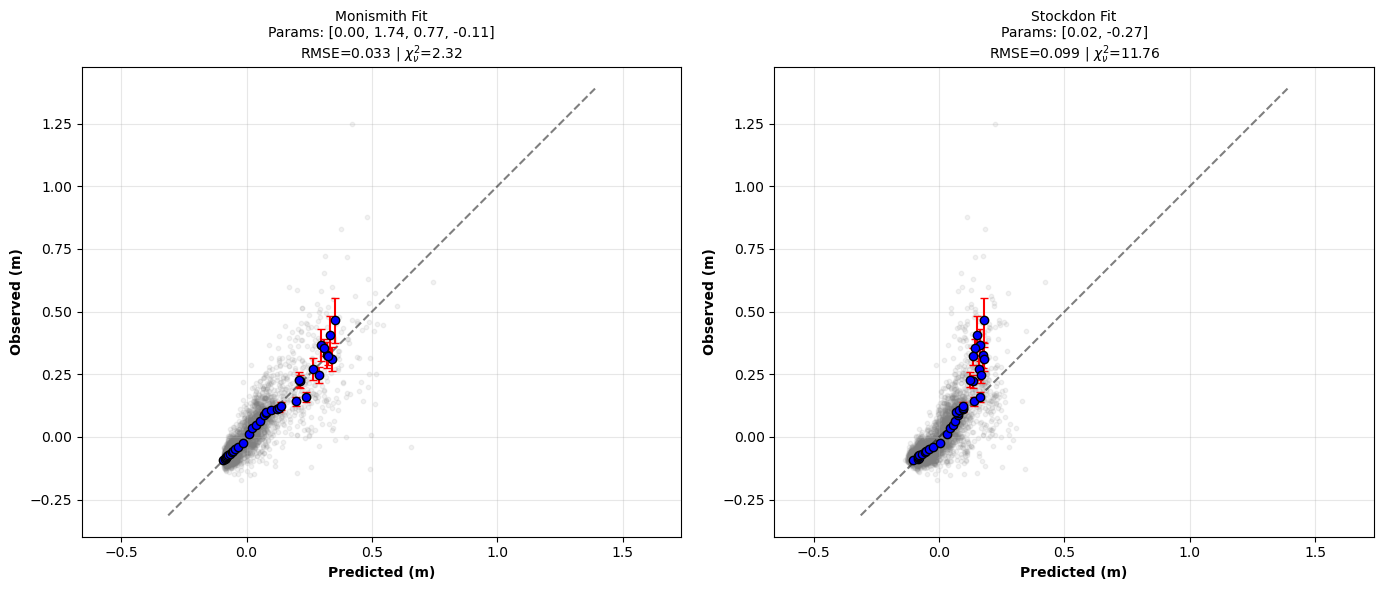

In [4]:
# define models
def monismith_offset(X, a, b, c, d):
    H, L = X
    return a * (H**b) * (L**c) + d

def stockdon_fit(X, m, k):
    H, L = X
    return m * np.sqrt(H * L) + k

# run model fit script
# Monismith 
res_mon = fit_model(
    model_func=monismith_offset,
    binned_df=binned_df,
    x_cols=['H0_mean', 'L0_mean'], 
    p0=[0.1, -2.0, 0.0, -0.15],
    bounds=([0, -5, -5, -0.5], [np.inf, 5, 5, 0.5]),
    label="Monismith Fit"
)
# Fit Stockdon 
res_stk = fit_model(
    model_func=stockdon_fit,
    binned_df=binned_df,
    x_cols=['H0_mean', 'L0_mean'],
    p0=[0.06, 0.0],                
    bounds=([0.0, -0.5], [np.inf, 0.5]), 
    label="Stockdon Fit"
)
# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_model(res_mon, binned_df, bulk_df, raw_x_cols=['H0', 'L0'], ax=axes[0])
plot_model(res_stk, binned_df, bulk_df, raw_x_cols=['H0', 'L0'], ax=axes[1])

plt.tight_layout()
plt.show()

#### Plottinf coefficients against one another

Scanning exponent grid...


<>:72: SyntaxWarning: invalid escape sequence '\e'
<>:72: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5901/3268855496.py:72: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'RMSE: $\eta = a H^b L^c + d$', fontsize=14)


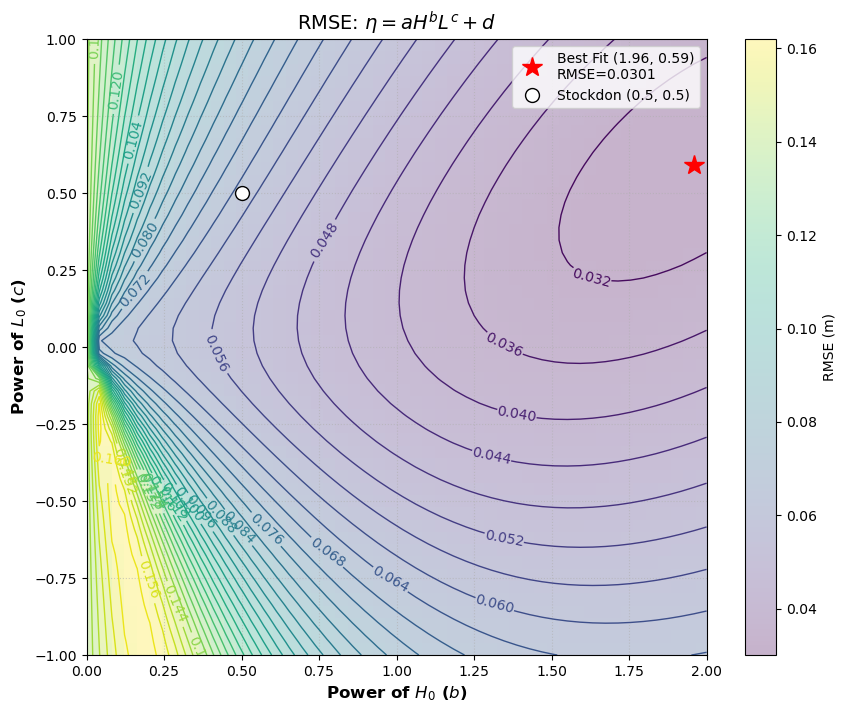

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_rmse_landscape(binned_df, h_col, l_col, y_col='n_mean', 
                        b_range=np.linspace(0, 1.5, 50), 
                        c_range=np.linspace(-1.0, 1.0, 50),
                        true_stockdon_point=(0.5, 0.5)):
    """
    Scans a grid of exponents b (for H) and c (for L) to map RMSE.
    Model: y = a * (H^b * L^c) + d
    For each fixed pair of (b, c), it solves for the best 'a' and 'd' using linear regression.
    """
    
    # extract data 
    H = binned_df[h_col].values
    L = binned_df[l_col].values
    Y = binned_df[y_col].values
    
    # Initialize error grid
    rmse_grid = np.zeros((len(c_range), len(b_range)))
    
    # --- THE GRID SEARCH ---
    print("Scanning exponent grid...")
    for i, c_val in enumerate(c_range):
        for j, b_val in enumerate(b_range):
            # 1. Create the combined feature Z = H^b * L^c
            Z = (H**b_val) * (L**c_val)
            
            # 2. Linear Fit: Y = a*Z + d
            # np.polyfit(x, y, 1) returns [slope (a), intercept (d)]
            # This is much faster than curve_fit for this specific step
            try:
                coeffs = np.polyfit(Z, Y, 1)
                p = np.poly1d(coeffs)
                Y_pred = p(Z)
                
                # 3. Calculate RMSE
                rmse = np.sqrt(mean_squared_error(Y, Y_pred))
                rmse_grid[i, j] = rmse
            except:
                rmse_grid[i, j] = np.nan

    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Contour Plot
    CS = ax.contour(b_range, c_range, rmse_grid, levels=35, cmap='viridis', linewidths=1)
    ax.clabel(CS, inline=1, fontsize=10, fmt='%.3f') # Label the lines with RMSE values
    
    # Add a heatmap background
    im = ax.imshow(rmse_grid, extent=[b_range.min(), b_range.max(), c_range.min(), c_range.max()], 
                   origin='lower', aspect='auto', cmap='viridis', alpha=0.3)
    
    # --- FIND & MARK MINIMUM ---
    # Find the indices of the minimum RMSE in the grid
    min_idx = np.unravel_index(np.argmin(rmse_grid), rmse_grid.shape)
    best_c = c_range[min_idx[0]]
    best_b = b_range[min_idx[1]]
    min_rmse = rmse_grid[min_idx]
    
    # Mark the Optima
    ax.plot(best_b, best_c, 'r*', markersize=15, label=f'Best Fit ({best_b:.2f}, {best_c:.2f})\nRMSE={min_rmse:.4f}')
    
    # Mark Stockdon (The "Universal" Standard)
    ax.plot(true_stockdon_point[0], true_stockdon_point[1], 'ko', markersize=10, markerfacecolor='white', label='Stockdon (0.5, 0.5)')

    # Labels
    ax.set_xlabel(f'Power of $H_0$ ($b$)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Power of $L_0$ ($c$)', fontsize=12, fontweight='bold')
    ax.set_title(f'RMSE: $\eta = a H^b L^c + d$', fontsize=14)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    
    plt.colorbar(im, label='RMSE (m)')
    plt.show()
    
    return best_b, best_c

# --- USAGE ---
# Just run this one line to generate the Fiedler-style plot
# Adjust ranges if you want to zoom out (e.g., b_range=np.linspace(-2, 2, 50))
best_b, best_c = plot_rmse_landscape(
    binned_df, 
    h_col='H0_mean',   # Or 'H6_mean'
    l_col='L0_mean', 
    y_col='n_mean',
    b_range=np.linspace(0, 2.0, 50),   # Range for Height Power
    c_range=np.linspace(-1.0, 1.0, 50) # Range for Length Power
)

<>:65: SyntaxWarning: invalid escape sequence '\c'
<>:65: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5901/473179801.py:65: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'Weighted Error ($\chi^2$)', fontsize=14)


Scanning exponent grid (Weighted)...


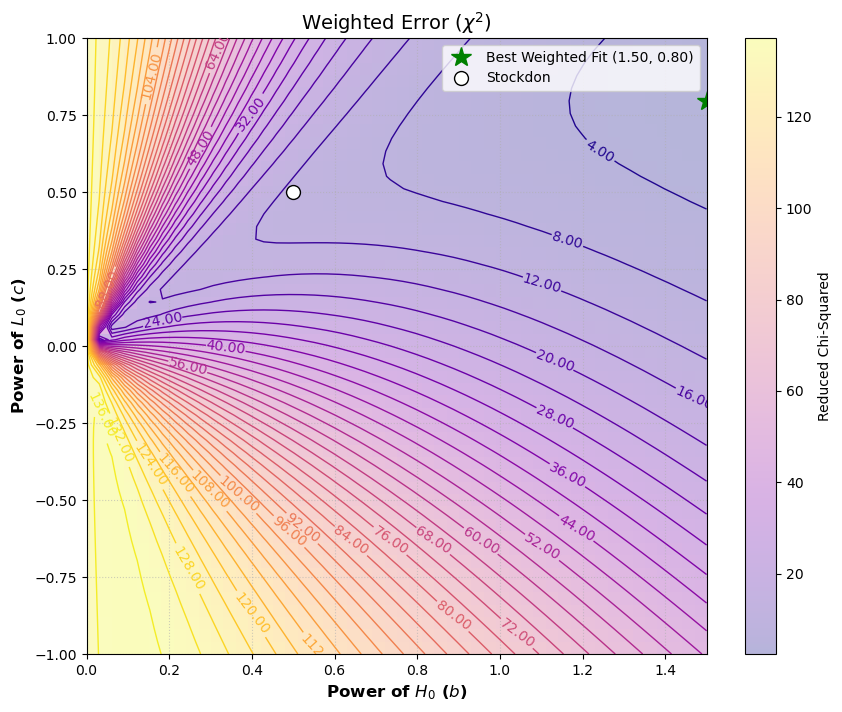

In [18]:
def plot_chisq_landscape(binned_df, h_col, l_col, y_col='n_mean', sigma_col='n_sem', 
                        b_range=np.linspace(0, 1.5, 50), 
                        c_range=np.linspace(-1.0, 1.0, 50),
                        true_stockdon_point=(0.5, 0.5)):
    """
    Scans exponent grid using WEIGHTED fitting (Chi-Squared) to match curve_fit.
    """
    
    # Extract data
    H = binned_df[h_col].values
    L = binned_df[l_col].values
    Y = binned_df[y_col].values
    Sigma = binned_df[sigma_col].values # <--- NEW: Get the error bars
    
    # Weights for polyfit are 1/sigma (because polyfit minimizes sum(w * residual)^2)
    weights = 1.0 / Sigma 
    
    # Initialize grid
    chi_grid = np.zeros((len(c_range), len(b_range)))
    
    print("Scanning exponent grid (Weighted)...")
    for i, c_val in enumerate(c_range):
        for j, b_val in enumerate(b_range):
            Z = (H**b_val) * (L**c_val)
            
            try:
                # 1. Weighted Linear Fit
                # We pass w=weights so it finds the best 'a' and 'd' respecting the error bars
                coeffs = np.polyfit(Z, Y, 1, w=weights)
                p = np.poly1d(coeffs)
                Y_pred = p(Z)
                
                # 2. Calculate Chi-Squared (Red)
                # This matches what curve_fit minimizes
                residuals = Y - Y_pred
                chi_sq = np.sum((residuals / Sigma)**2)
                
                # Store reduced Chi-sq (normalized by N) for easier reading
                chi_grid[i, j] = chi_sq / len(Y)
                
            except:
                chi_grid[i, j] = np.nan

    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Contour Plot (Now mapping Chi-Squared, not RMSE)
    CS = ax.contour(b_range, c_range, chi_grid, levels=35, cmap='plasma', linewidths=1)
    ax.clabel(CS, inline=1, fontsize=10, fmt='%.2f') 
    
    im = ax.imshow(chi_grid, extent=[b_range.min(), b_range.max(), c_range.min(), c_range.max()], 
                   origin='lower', aspect='auto', cmap='plasma', alpha=0.3)
    
    # Find Minimum
    min_idx = np.unravel_index(np.argmin(chi_grid), chi_grid.shape)
    best_c = c_range[min_idx[0]]
    best_b = b_range[min_idx[1]]
    min_chi = chi_grid[min_idx]
    
    ax.plot(best_b, best_c, 'g*', markersize=15, label=f'Best Weighted Fit ({best_b:.2f}, {best_c:.2f})')
    ax.plot(true_stockdon_point[0], true_stockdon_point[1], 'ko', markersize=10, markerfacecolor='white', label='Stockdon')

    ax.set_xlabel(f'Power of $H_0$ ($b$)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Power of $L_0$ ($c$)', fontsize=12, fontweight='bold')
    ax.set_title(f'Weighted Error ($\chi^2$)', fontsize=14)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.colorbar(im, label='Reduced Chi-Squared')
    plt.show()
    
    return best_b, best_c

# --- RUN THIS ---
best_b, best_c = plot_chisq_landscape(
    binned_df, 
    h_col='H0_mean', 
    l_col='L0_mean', 
    y_col='n_mean',
    sigma_col='n_sem' # <--- Pass the weights!
)

<>:93: SyntaxWarning: invalid escape sequence '\c'
<>:96: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:101: SyntaxWarning: invalid escape sequence '\e'
<>:93: SyntaxWarning: invalid escape sequence '\c'
<>:96: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:101: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5901/4010140192.py:93: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(best_b, best_c, 'g*', markersize=15, label=f'Best $\chi^2$ ({best_b:.2f}, {best_c:.2f})')
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5901/4010140192.py:96: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("$\chi^2$ Landscape (Weighted)", fontsize=12)
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_5901/4010140192.py:100: SyntaxWarning: invalid escape sequence '\c'
  plt.colorbar(im2, ax=ax, label='Reduced $\chi^

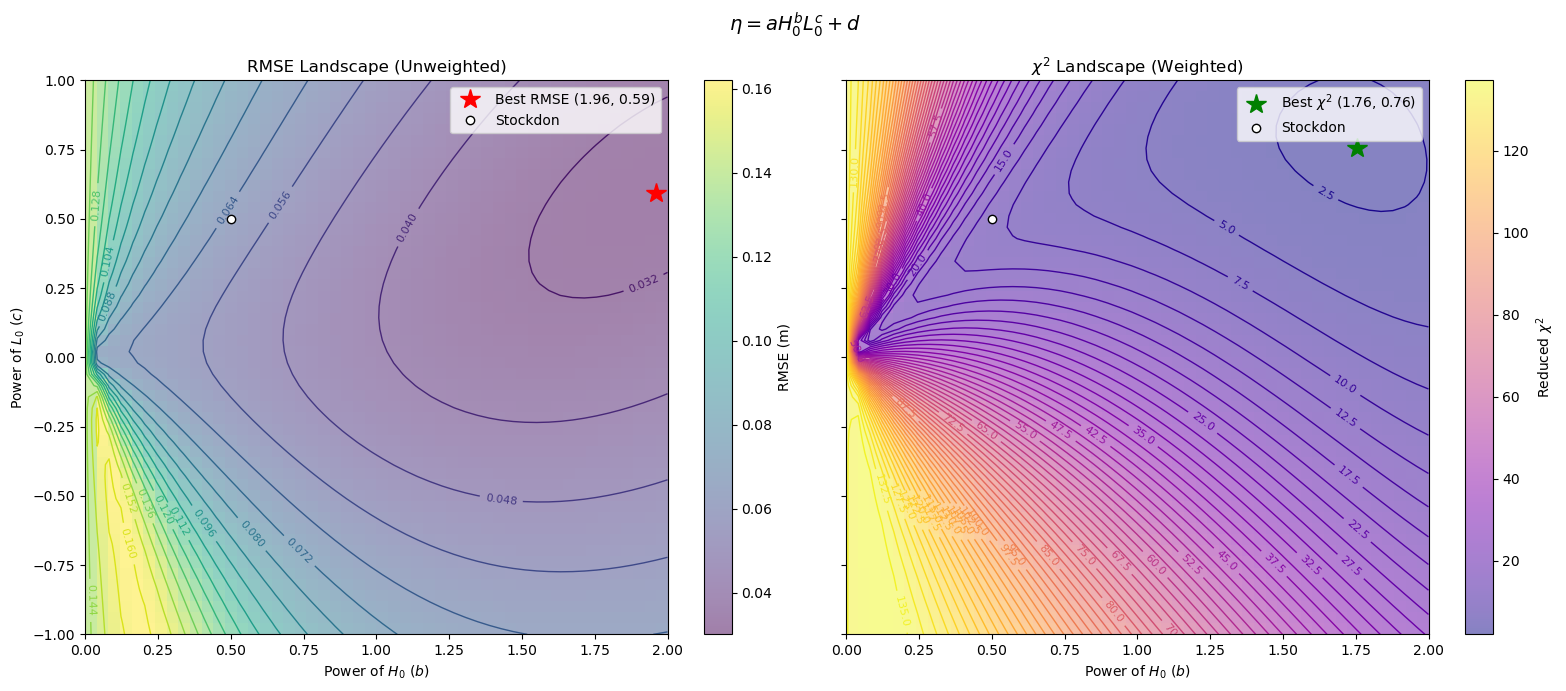

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_landscape_grid(binned_df, h_col, l_col, y_col, sigma_col=None, 
                       b_range=np.linspace(0, 2.0, 50), 
                       c_range=np.linspace(-1.0, 1.0, 50), 
                       mode='rmse'):
    """
    Calculates the error grid for either RMSE (Unweighted) or Chi-Squared (Weighted).
    """
    H = binned_df[h_col].values
    L = binned_df[l_col].values
    Y = binned_df[y_col].values
    
    # Determine Weights
    if mode == 'chi2':
        if sigma_col is None: raise ValueError("Chi2 mode requires sigma_col")
        Sigma = binned_df[sigma_col].values
        weights = 1.0 / Sigma
    else:
        weights = None # Unweighted for RMSE
        
    grid = np.zeros((len(c_range), len(b_range)))
    
    for i, c_val in enumerate(c_range):
        for j, b_val in enumerate(b_range):
            Z = (H**b_val) * (L**c_val)
            try:
                # Linear Fit (Weighted or Unweighted)
                coeffs = np.polyfit(Z, Y, 1, w=weights)
                p = np.poly1d(coeffs)
                Y_pred = p(Z)
                
                if mode == 'chi2':
                    # Calculate Reduced Chi-Squared
                    residuals = Y - Y_pred
                    chi_sq = np.sum((residuals / Sigma)**2)
                    grid[i, j] = chi_sq / len(Y)
                else:
                    # Calculate RMSE
                    grid[i, j] = np.sqrt(np.mean((Y - Y_pred)**2))
            except:
                grid[i, j] = np.nan
                
    return grid, b_range, c_range

def plot_comparison(binned_df, h_col='H0_mean', l_col='L0_mean', y_col='n_mean', sigma_col='n_sem'):
    
    # Settings for the scan
    b_vals = np.linspace(0, 2.0, 50)   # Power of H
    c_vals = np.linspace(-1.0, 1.0, 50) # Power of L
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # --- 1. RMSE (Unweighted) ---
    ax = axes[0]
    grid_rmse, bb, cc = get_landscape_grid(binned_df, h_col, l_col, y_col, 
                                           b_range=b_vals, c_range=c_vals, mode='rmse')
    
    # Plot
    im1 = ax.imshow(grid_rmse, extent=[bb.min(), bb.max(), cc.min(), cc.max()], 
                   origin='lower', aspect='auto', cmap='viridis', alpha=0.5)
    CS1 = ax.contour(bb, cc, grid_rmse, levels=20, cmap='viridis', linewidths=1)
    ax.clabel(CS1, inline=1, fontsize=8)
    
    # Minima
    min_idx = np.unravel_index(np.argmin(grid_rmse), grid_rmse.shape)
    best_b, best_c = bb[min_idx[1]], cc[min_idx[0]]
    ax.plot(best_b, best_c, 'r*', markersize=15, label=f'Best RMSE ({best_b:.2f}, {best_c:.2f})')
    ax.plot(0.5, 0.5, 'ko', markerfacecolor='white', label='Stockdon')
    
    ax.set_title("RMSE Landscape (Unweighted)", fontsize=12)
    ax.set_xlabel('Power of $H_0$ ($b$)')
    ax.set_ylabel('Power of $L_0$ ($c$)')
    ax.legend()
    plt.colorbar(im1, ax=ax, label='RMSE (m)')

    # --- 2. CHI-SQUARED (Weighted) ---
    ax = axes[1]
    grid_chi, bb, cc = get_landscape_grid(binned_df, h_col, l_col, y_col, sigma_col=sigma_col,
                                          b_range=b_vals, c_range=c_vals, mode='chi2')
    
    # Plot
    im2 = ax.imshow(grid_chi, extent=[bb.min(), bb.max(), cc.min(), cc.max()], 
                   origin='lower', aspect='auto', cmap='plasma', alpha=0.5)
    CS2 = ax.contour(bb, cc, grid_chi, levels=55, cmap='plasma', linewidths=1)
    ax.clabel(CS2, inline=1, fontsize=8)
    
    # Minima
    min_idx = np.unravel_index(np.argmin(grid_chi), grid_chi.shape)
    best_b, best_c = bb[min_idx[1]], cc[min_idx[0]]
    ax.plot(best_b, best_c, 'g*', markersize=15, label=f'Best $\chi^2$ ({best_b:.2f}, {best_c:.2f})')
    ax.plot(0.5, 0.5, 'ko', markerfacecolor='white', label='Stockdon')
    
    ax.set_title("$\chi^2$ Landscape (Weighted)", fontsize=12)
    ax.set_xlabel('Power of $H_0$ ($b$)')
    ax.set_yticklabels([]) 
    ax.legend()
    plt.colorbar(im2, ax=ax, label='Reduced $\chi^2$')
    plt.suptitle( f'$\eta = a H_0^b L_0^c + d$', fontsize=14)

    plt.tight_layout()
    plt.show()

# --- RUN IT ---
plot_comparison(binned_df, h_col='H0_mean', l_col='L0_mean', y_col='n_mean', sigma_col='n_sem')